<a href="https://colab.research.google.com/github/Thejasvenan/EN3150_A03_Vision/blob/main/PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [15]:

# Set seed for reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
import kagglehub

# Download latest dataset
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Dataset root folder
updated_path = os.path.join(path, 'rice_leaf_diseases')
print(os.listdir(updated_path))

# Class folders
Leaf_smut = os.path.join(updated_path, 'Leaf smut')
leaf_blight = os.path.join(updated_path, 'Bacterial leaf blight')
Brown_spot = os.path.join(updated_path, 'Brown spot')

# Check sample files
print("Leaf smut files:", os.listdir(Leaf_smut)[:5])
print("Leaf blight files:", os.listdir(leaf_blight)[:5])
print("Brown spot files:", os.listdir(Brown_spot)[:5])

Using Colab cache for faster access to the 'rice-leaf-diseases' dataset.
Path to dataset files: /kaggle/input/rice-leaf-diseases
['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Leaf smut files: ['DSC_0330.jpg', 'DSC_0313.JPG', 'DSC_0515.jpg', 'DSC_0315.jpg', 'DSC_0338.JPG']
Leaf blight files: ['DSC_0372.JPG', 'DSC_0374.JPG', 'DSC_0398.JPG', 'DSC_0396.JPG', 'DSC_0370.jpg']
Brown spot files: ['DSC_0305.JPG', 'DSC_0394.jpg', 'DSC_0105.jpg', 'DSC_0104.jpg', 'DSC_0325.JPG']


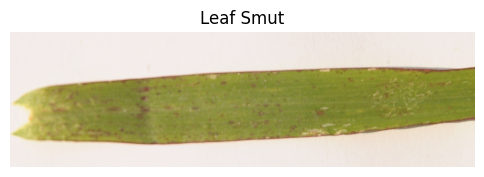

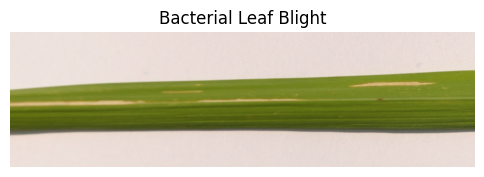

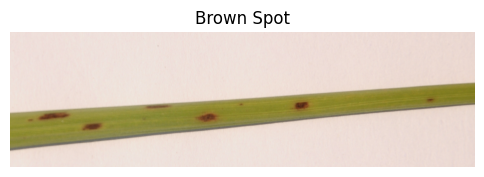

In [17]:

i = 20

Leaf_smut_1 = Image.open(os.path.join(Leaf_smut, os.listdir(Leaf_smut)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Leaf_smut_1)
plt.axis('off')
plt.title("Leaf Smut")
plt.show()

leaf_blight_1 = Image.open(os.path.join(leaf_blight, os.listdir(leaf_blight)[i]))
plt.figure(figsize=(6,6))
plt.imshow(leaf_blight_1)
plt.axis('off')
plt.title("Bacterial Leaf Blight")
plt.show()

Brown_spot_1 = Image.open(os.path.join(Brown_spot, os.listdir(Brown_spot)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Brown_spot_1)
plt.axis('off')
plt.title("Brown Spot")
plt.show()

In [43]:
# Split dataset into train/val/test directories

output_base = "dataset_split"

for folder in ["train", "val", "test"]:
    for cls in ["Leaf smut", "Bacterial leaf blight", "Brown spot"]:
        os.makedirs(os.path.join(output_base, folder, cls), exist_ok=True)

# Function to copy files
def split_and_copy(class_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    files = os.listdir(class_folder)
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    for f in files[:n_train]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "train", class_name, f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "val", class_name, f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "test", class_name, f))

# Split each class
split_and_copy(Leaf_smut, "Leaf smut")
split_and_copy(leaf_blight, "Bacterial leaf blight")
split_and_copy(Brown_spot, "Brown spot")


In [51]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 10

In [45]:
import cv2

In [30]:
'''def texture_enhance(img):
    # Ensure the input is 8-bit for OpenCV operations
    img = np.uint8(img * 255)  # convert from [0,1] float → [0,255] uint8

    # Convert RGB → Lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)

    # Merge channels and convert back to RGB
    lab = cv2.merge((l,a,b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Add small Gaussian noise to enhance texture diversity
    noise = np.random.normal(0, 5, img.shape).astype(np.int16)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Convert back to float32 for Keras
    img = img.astype(np.float32) / 255.0
    return img'''

'def texture_enhance(img):\n    # Ensure the input is 8-bit for OpenCV operations\n    img = np.uint8(img * 255)  # convert from [0,1] float → [0,255] uint8\n    \n    # Convert RGB → Lab\n    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)\n    l, a, b = cv2.split(lab)\n    \n    # Apply CLAHE on L channel\n    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))\n    l = clahe.apply(l)\n    \n    # Merge channels and convert back to RGB\n    lab = cv2.merge((l,a,b))\n    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)\n\n    # Add small Gaussian noise to enhance texture diversity\n    noise = np.random.normal(0, 5, img.shape).astype(np.int16)\n    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)\n    \n    # Convert back to float32 for Keras\n    img = img.astype(np.float32) / 255.0\n    return img'

In [52]:

# Training augmentation
'''train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)'''


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    #preprocessing_function=texture_enhance,  # <---- Key enhancement
    fill_mode='nearest'
)

# Validation & test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 116 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [53]:

# Build CNN Model
def build_simple_cnn(input_shape=(128,128,3), num_classes=3, dropout_rate=0.5):
    model = models.Sequential()
    # Conv block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten & Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=3, dropout_rate=0.5)
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,612,867 (32.86 MB)

 Trainable params: 8,612,867 (32.86 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:

adam_epochs = 20

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2331 - loss: 1.1788 - val_accuracy: 0.4773 - val_loss: 1.0879
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3571 - loss: 1.1243 - val_accuracy: 0.5227 - val_loss: 1.0640
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4313 - loss: 1.0514 - val_accuracy: 0.5909 - val_loss: 1.0109
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5189 - loss: 1.0130 - val_accuracy: 0.6591 - val_loss: 0.9404
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5201 - loss: 0.9865 - val_accuracy: 0.5455 - val_loss: 0.8928
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5167 - loss: 0.9654 - val_accuracy: 0.5455 - val_loss: 0.8979
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5281 - loss: 0.9232 - val_accuracy: 0.6136 - val_loss: 0.8525
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5270 - loss: 0.9176 - val_accuracy: 0.5682 - val_loss:

In [ ]:

'''total_epochs = 40
sgd_epochs = 5
adam_epochs = total_epochs - sgd_epochs

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)

# Then, SGD
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=sgd_epochs
)'''


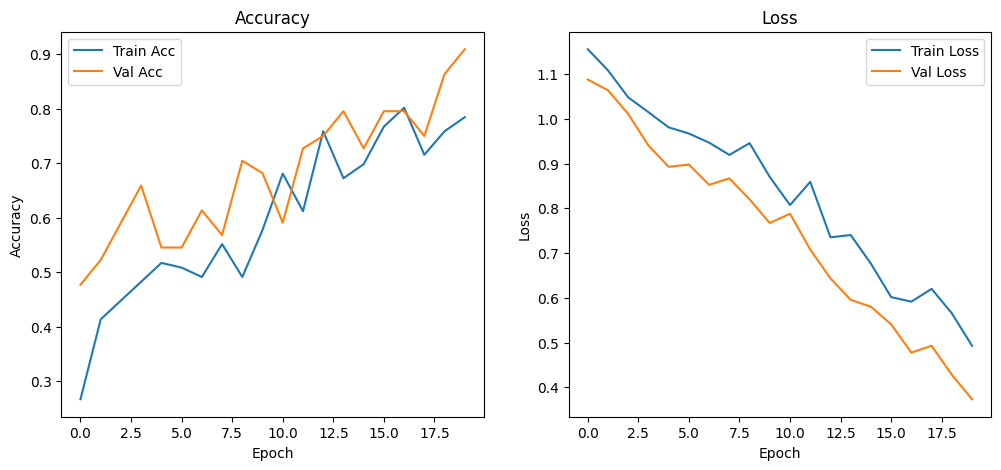

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_adam.history['accuracy'], label='Train Acc')
plt.plot(history_adam.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9486 - loss: 0.2767
Test Accuracy: 89.58%
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


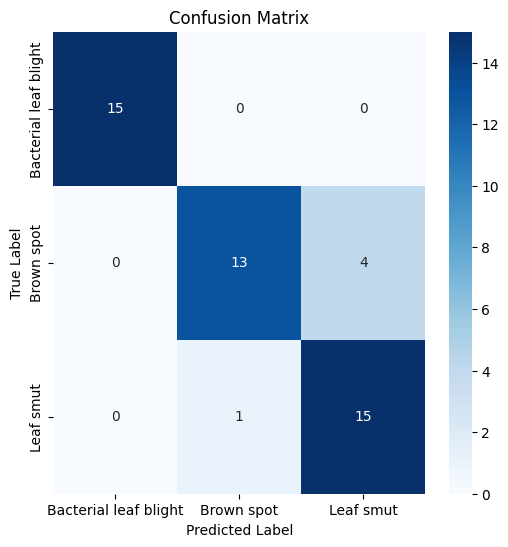

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00        15
           Brown spot       0.93      0.76      0.84        17
            Leaf smut       0.79      0.94      0.86        16

             accuracy                           0.90        48
            macro avg       0.91      0.90      0.90        48
         weighted avg       0.90      0.90      0.90        48



In [56]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))